Training Loop Glimpse

/tmp/ipython-input-2-1280733185.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2-1280733185.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Training Data Sample:
                Close        MA5  u
Date                               
2016-01-07  76.891998  78.785199  0
2016-01-08  77.063004  78.096600  0
2016-01-11  76.671997  77.624800  0
2016-01-12  76.197998  77.068199  0
2016-01-13  76.626999  76.690399  0


Training Episodes: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


Training completed.



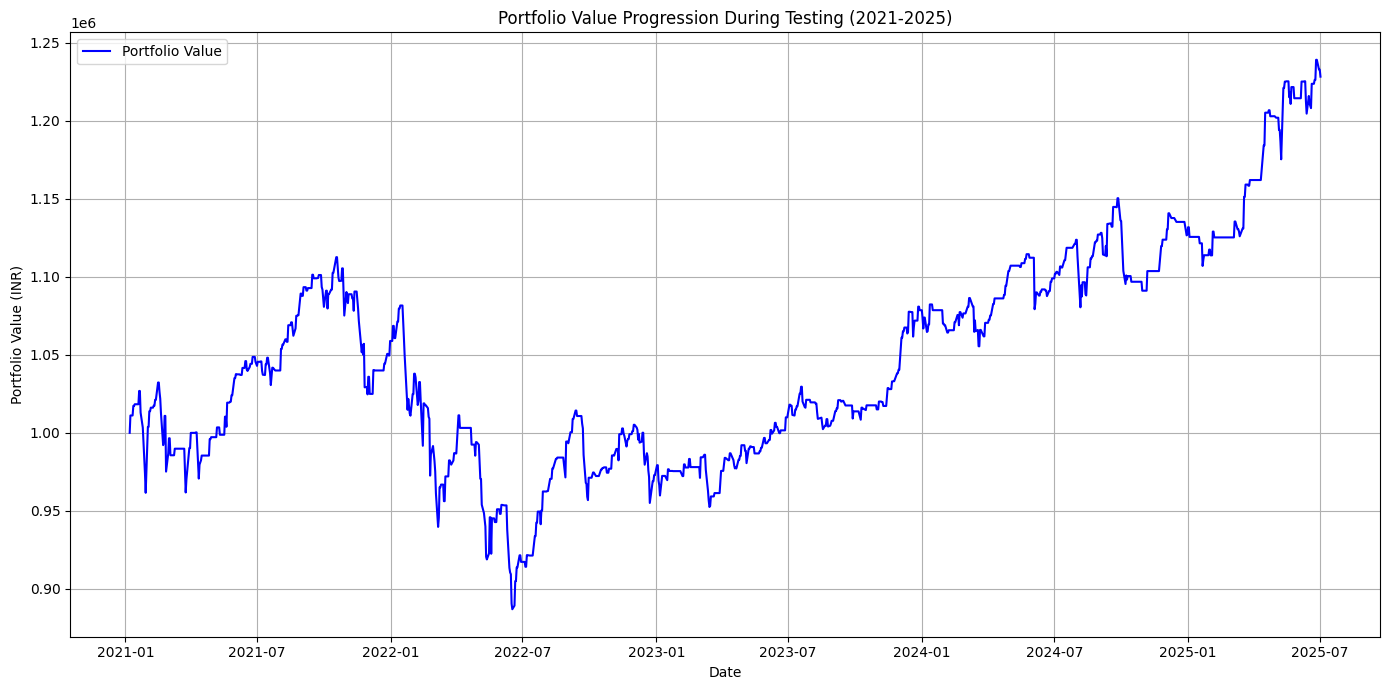

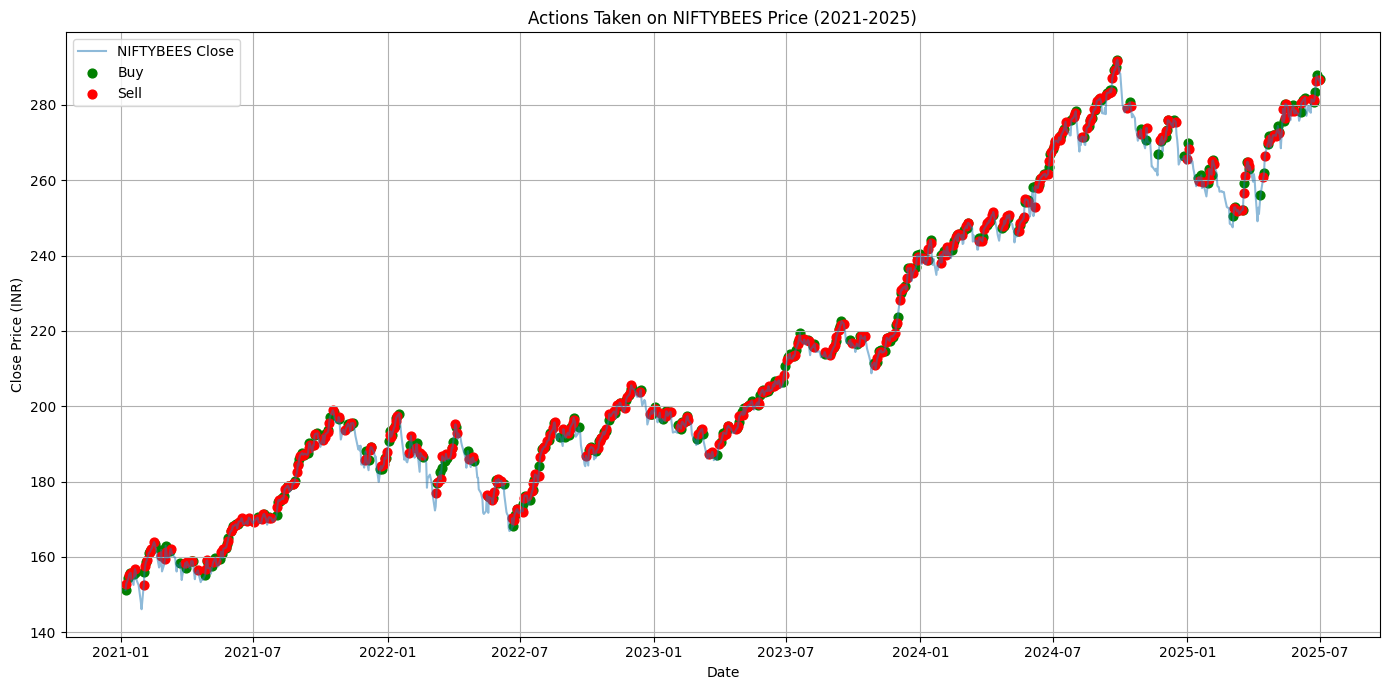

Final Q-table after training:
[[430197.02579326      0.         444759.73658537]
 [     0.         353312.79743656 364931.38340869]
 [240225.22256786      0.         235174.568927  ]
 [     0.         259886.69751785 255733.92356073]]

Final portfolio value after testing: ₹1,228,328.38


In [2]:


import yfinance as yf
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ==== PARAMETERS ====
num_episodes = 100
epsilon_start = 1.0
epsilon_min = 0.15
epsilon_decay = 0.99  # 1% decay per episode
alpha = 0.1
gamma = 0.2
initial_cash = 1_000_000

# ==== DATA PREPARATION ====
def prepare_data(symbol, start, end):
    # Download data and handle multi-index columns
    df = yf.download(symbol, start=start, end=end)

    # Flatten multi-index columns if they exist
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    else:
        df.columns = [col.strip() for col in df.columns.values]

    # Select and rename close price column
    close_col = [col for col in df.columns if 'Close' in col][0]
    df = df[[close_col]].copy()
    df.rename(columns={close_col: 'Close'}, inplace=True)

    # Calculate indicators
    df['MA5'] = df['Close'].rolling(5).mean()
    df = df.dropna()
    df['u'] = (df['Close'] > df['MA5']).astype(int)

    return df

# Training and testing datasets
df_train = prepare_data('NIFTYBEES.NS', '2016-01-01', '2020-12-31')
df_test = prepare_data('NIFTYBEES.NS', '2021-01-01', '2025-12-31')

print("Training Data Sample:")
print(df_train.head())

# ==== Q-LEARNING SETUP ====
def get_state(u, t):
    return u * 2 + t  # u: 0/1, t: 0/1

q_table = np.zeros((4, 3))  # 4 states, 3 actions (Buy, Sell, Hold)

# ==== TRAINING LOOP ====
for episode in tqdm(range(num_episodes), desc='Training Episodes'):
    epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))
    current_t = 0  # 0 = all cash, 1 = all stocks
    current_cash = initial_cash
    current_shares = 0

    for i in range(len(df_train) - 1):
        current_u = df_train['u'].iloc[i]
        state = get_state(current_u, current_t)

        # Valid actions
        if current_t == 0:
            valid_actions = [0, 2]  # Buy, Hold
        else:
            valid_actions = [1, 2]  # Sell, Hold

        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = np.random.choice(valid_actions)
        else:
            q_values = q_table[state, valid_actions]
            action = valid_actions[np.argmax(q_values)]

        close_price = df_train['Close'].iloc[i]

        # Execute action
        if action == 0:  # Buy
            shares_to_buy = int(current_cash // close_price)
            cost = shares_to_buy * close_price
            leftover_cash = current_cash - cost
            current_shares += shares_to_buy
            current_cash = leftover_cash
            current_t = 1
        elif action == 1:  # Sell
            proceeds = current_shares * close_price
            current_cash += proceeds
            current_shares = 0
            current_t = 0
        # Hold does not change position

        # Calculate reward as total portfolio value (absolute INR)
        portfolio_value = current_cash + current_shares * close_price
        reward = portfolio_value

        # Next state
        next_u = df_train['u'].iloc[i + 1]
        next_state = get_state(next_u, current_t)

        # Q-learning update
        next_max = np.max(q_table[next_state, [0, 1, 2]])
        q_table[state, action] += alpha * (reward + gamma * next_max - q_table[state, action])

trained_q_table = q_table.copy()
print("Training completed.\n")

# ==== TESTING FUNCTION ====
def test_strategy(q_table, df):
    current_t = 0
    current_cash = initial_cash
    current_shares = 0
    portfolio_values = []
    actions_taken = []

    for i in range(len(df)):
        current_u = df['u'].iloc[i]
        state = get_state(current_u, current_t)

        if current_t == 0:
            valid_actions = [0, 2]
        else:
            valid_actions = [1, 2]

        # Greedy action selection (no exploration)
        q_values = q_table[state, valid_actions]
        action = valid_actions[np.argmax(q_values)]
        actions_taken.append(action)

        close_price = df['Close'].iloc[i]

        if action == 0:  # Buy
            shares_to_buy = int(current_cash // close_price)
            cost = shares_to_buy * close_price
            leftover_cash = current_cash - cost
            current_shares += shares_to_buy
            current_cash = leftover_cash
            current_t = 1
        elif action == 1:  # Sell
            proceeds = current_shares * close_price
            current_cash += proceeds
            current_shares = 0
            current_t = 0
        # Hold does not change position

        portfolio_value = current_cash + current_shares * close_price
        portfolio_values.append(portfolio_value)

    return portfolio_values, actions_taken

# ==== RUN TEST ====
test_portfolio_values, actions_taken = test_strategy(trained_q_table, df_test)

# ==== VISUALIZATION ====
plt.figure(figsize=(14, 7))
plt.plot(df_test.index, test_portfolio_values, label='Portfolio Value', color='blue')
plt.title('Portfolio Value Progression During Testing (2021-2025)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Visualize actions on price chart
action_map = {0: 'Buy', 1: 'Sell', 2: 'Hold'}
action_colors = {0: 'green', 1: 'red', 2: 'gray'}
action_dates = df_test.index

plt.figure(figsize=(14, 7))
plt.plot(df_test.index, df_test['Close'], label='NIFTYBEES Close', alpha=0.5)
for act in [0, 1]:
    idxs = [i for i, a in enumerate(actions_taken) if a == act]
    plt.scatter(df_test.index[idxs], df_test['Close'].iloc[idxs],
                label=action_map[act], color=action_colors[act], marker='o', s=40)
plt.title('Actions Taken on NIFTYBEES Price (2021-2025)')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== OUTPUTS ====
print("Final Q-table after training:")
print(trained_q_table)
print(f"\nFinal portfolio value after testing: ₹{test_portfolio_values[-1]:,.2f}")


Importing Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

Parameters Initialisation(except alpha and gamma, all are constant)

In [2]:
# ==== PARAMETERS ====
num_episodes = 100
epsilon_start = 1.0
epsilon_min = 0.15
epsilon_decay = 0.99  # 1% decay per episode
# alpha = 0.1
# gamma = 0.2
initial_cash = 1_000_000

DATA PREPARATION

In [3]:
# ==== DATA PREPARATION ====
def prepare_data(symbol, start, end):
    # Download data and handle multi-index columns
    df = yf.download(symbol, start=start, end=end)

    # Flatten multi-index columns if they exist
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    else:
        df.columns = [col.strip() for col in df.columns.values]

    # Select and rename close price column
    close_col = [col for col in df.columns if 'Close' in col][0]
    df = df[[close_col]].copy()
    df.rename(columns={close_col: 'Close'}, inplace=True)

    # Calculate indicators
    df['MA5'] = df['Close'].rolling(5).mean()
    df = df.dropna()
    df['u'] = (df['Close'] > df['MA5']).astype(int)

    return df

# Training and testing datasets
df_train = prepare_data('NIFTYBEES.NS', '2016-01-01', '2020-12-31')
df_test = prepare_data('NIFTYBEES.NS', '2021-01-01', '2025-12-31')

print("Training Data Sample:")
print(df_train.head())

/tmp/ipython-input-3-4132056277.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-4132056277.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Training Data Sample:
                Close        MA5  u
Date                               
2016-01-07  76.891998  78.785199  0
2016-01-08  77.063004  78.096600  0
2016-01-11  76.671997  77.624800  0
2016-01-12  76.197998  77.068199  0
2016-01-13  76.626999  76.690399  0


Data preparation separately was not needed because in later cell, we are again preparing data and converting it to numpy array for faster access.

STATE SETUP

In [4]:
# ==== Q-LEARNING SETUP ====
def get_state(u, t):
    return u * 2 + t  # u: 0/1, t: 0/1

q_table = np.zeros((4, 3))  # 4 states, 3 actions (Buy, Sell, Hold)

In [5]:
pv = []

In [10]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 23.7 MB/s eta 0:00:00


PARAMETER HYPERTUNING USING OPTUNA

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import optuna

# ==== PARAMETERS (Global, accessible to objective function) ====
num_episodes = 100
epsilon_start = 1.0
epsilon_min = 0.15
epsilon_decay = 0.99
initial_cash = 1_000_000

# ==== DATA PREPARATION (Global, accessible to objective function) ====
def prepare_data(symbol, start, end):
    df = yf.download(symbol, start=start, end=end)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    else:
        df.columns = [col.strip() for col in df.columns.values]
    close_col = [col for col in df.columns if 'Close' in col][0]
    df = df[[close_col]].copy()
    df.rename(columns={close_col: 'Close'}, inplace=True)
    df['MA5'] = df['Close'].rolling(5).mean()
    df = df.dropna()
    df['u'] = (df['Close'] > df['MA5']).astype(int)
    return df

df_train = prepare_data('NIFTYBEES.NS', '2016-01-01', '2020-12-31')
df_test = prepare_data('NIFTYBEES.NS', '2021-01-01', '2025-12-31')

# === Crucial Optimization: Convert Pandas Series to NumPy arrays once ===
df_train_u_np = df_train['u'].values
df_train_close_np = df_train['Close'].values
df_test_u_np = df_test['u'].values
df_test_close_np = df_test['Close'].values

# ==== Q-LEARNING SETUP (Global, accessible to objective function) ====
def get_state(u, t):
    return u * 2 + t

# === test_strategy function moved outside, optimized for NumPy arrays ===
def test_strategy(q_table, df_u_np, df_close_np):
    current_t = 0
    current_cash = initial_cash
    current_shares = 0
    portfolio_values = []
    # actions_taken = [] # Not used for return, can be commented out if not needed

    for i in range(len(df_u_np)):
        current_u = df_u_np[i]
        state = get_state(current_u, current_t)

        if current_t == 0:
            valid_actions = [0, 2] # Buy, Hold
        else:
            valid_actions = [1, 2] # Sell, Hold

        q_values = q_table[state, valid_actions]
        # action = valid_actions[np.argmax(q_values)] # No epsilon-greedy, just greedy
        # If multiple actions have the same max Q-value, np.argmax returns the first one.
        # This is fine for greedy selection.
        action = valid_actions[np.argmax(q_values)]
        # actions_taken.append(action)

        close_price = df_close_np[i]

        if action == 0:  # Buy
            shares_to_buy = int(current_cash // close_price)
            cost = shares_to_buy * close_price
            leftover_cash = current_cash - cost
            current_shares += shares_to_buy
            current_cash = leftover_cash
            current_t = 1
        elif action == 1:  # Sell
            proceeds = current_shares * close_price
            current_cash += proceeds
            current_shares = 0
            current_t = 0
        # Hold does not change position

        portfolio_value = current_cash + current_shares * close_price
        portfolio_values.append(portfolio_value)

    return portfolio_values # Return only values, as actions_taken is not used for optimization

# ==== OPTUNA OBJECTIVE FUNCTION ====
def objective(trial):
    # Suggest hyperparameters to Optuna
    alpha = trial.suggest_float('alpha', 0.01, 0.99) # Original range was 0.01*1 to 0.01*99
    gamma = trial.suggest_float('gamma', 0.01, 0.99) # Original range was 0.01*1 to 0.01*99

    # Q-table needs to be re-initialized for each trial
    q_table = np.zeros((4, 3)) # State space 4 (u*2+t), Action space 3 (Buy, Sell, Hold)

    # ==== TRAINING LOOP ====
    # Use tqdm for episodes, but not for trials unless you want a global bar
    for episode in tqdm(range(num_episodes), desc=f'Trial {trial.number} (A={alpha:.2f}, G={gamma:.2f})'):
        epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))
        current_t = 0
        current_cash = initial_cash
        current_shares = 0

        # Loop over optimized NumPy arrays
        for i in range(len(df_train_u_np) - 1):
            current_u = df_train_u_np[i]
            state = get_state(current_u, current_t)

            if current_t == 0:
                valid_actions = [0, 2]
            else:
                valid_actions = [1, 2]

            if np.random.random() < epsilon:
                action = np.random.choice(valid_actions)
            else:
                q_values = q_table[state, valid_actions]
                action = valid_actions[np.argmax(q_values)]

            close_price = df_train_close_np[i]

            if action == 0:  # Buy
                shares_to_buy = int(current_cash // close_price)
                cost = shares_to_buy * close_price
                leftover_cash = current_cash - cost
                current_shares += shares_to_buy
                current_cash = leftover_cash
                current_t = 1
            elif action == 1:  # Sell
                proceeds = current_shares * close_price
                current_cash += proceeds
                current_shares = 0
                current_t = 0

            portfolio_value = current_cash + current_shares * close_price
            reward = portfolio_value

            next_u = df_train_u_np[i + 1]
            next_state = get_state(next_u, current_t)

            next_max = np.max(q_table[next_state, [0, 1, 2]])
            q_table[state, action] += alpha * (reward + gamma * next_max - q_table[state, action])
    trained_q_table = q_table.copy()

    # ==== RUN TEST ====
    # Pass optimized NumPy arrays to test_strategy
    test_portfolio_values = test_strategy(trained_q_table, df_test_u_np, df_test_close_np)

    # Optuna by default minimizes. To maximize portfolio value, return negative of it.
    # Or set direction='maximize' in create_study. Let's use maximize.
    final_portfolio_value = test_portfolio_values[-1]

    # You can also report intermediate values for pruning (early stopping)
    # trial.report(final_portfolio_value, step=num_episodes) # Report after each training run
    # if trial.should_prune():
    #     raise optuna.exceptions.TrialPruned()

    return final_portfolio_value

# ==== RUN OPTUNA STUDY ====
if __name__ == "__main__": # Standard practice for executable code
    print("Starting Optuna hyperparameter optimization...")
    # Create a study object and optimize the objective function.
    # We want to maximize the portfolio value, so set direction='maximize'.
    study = optuna.create_study(direction='maximize', study_name='Q_Learning_Portfolio_Optimization')

    # Run the optimization for a certain number of trials.
    # Start with a smaller number (e.g., 50-100) to see if it works well.
    # 200-500 trials is often a good balance for this kind of problem.
    num_optuna_trials = 500
    study.optimize(objective, n_trials=num_optuna_trials)

    print("\nOptimization finished!")
    print(f"Number of finished trials: {len(study.trials)}")
    print(f"Best trial:")
    trial = study.best_trial

    print(f"  Value (Max Portfolio Value): ₹{trial.value:,.2f}")
    print(f"  Best Alpha (Learning Rate): {trial.params['alpha']:.4f}")
    print(f"  Best Gamma (Discount Factor): {trial.params['gamma']:.4f}")

    #You can also access all trials results
    print("\nAll trial results:")
    for t in study.trials:
        print(f"Trial {t.number}: Value = {t.value:.2f}, Params = {t.params}")

    #To visualize the results (requires plotly or matplotlib)

    try:
        optuna.visualization.plot_optimization_history(study).show()
        optuna.visualization.plot_param_importances(study).show()
    except ImportError:
        print("Plotly and/or Matplotlib not installed. Cannot generate plots.")

/tmp/ipython-input-14-2077032626.py:16: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-14-2077032626.py:16: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
[I 2025-07-03 04:11:14,644] A new study created in memory with name: Q_Learning_Portfolio_Optimization


Starting Optuna hyperparameter optimization...


Trial 0 (A=0.16, G=0.02): 100%|██████████| 100/100 [00:03<00:00, 31.30it/s]
[I 2025-07-03 04:11:17,859] Trial 0 finished with value: 1000000.0 and parameters: {'alpha': 0.15751577828138885, 'gamma': 0.018991251533372562}. Best is trial 0 with value: 1000000.0.
Trial 1 (A=0.61, G=0.41): 100%|██████████| 100/100 [00:03<00:00, 33.00it/s]
[I 2025-07-03 04:11:20,901] Trial 1 finished with value: 1229273.9415130615 and parameters: {'alpha': 0.6054190352068277, 'gamma': 0.4143158082894823}. Best is trial 1 with value: 1229273.9415130615.
Trial 2 (A=0.69, G=0.60): 100%|██████████| 100/100 [00:03<00:00, 32.75it/s]
[I 2025-07-03 04:11:23,965] Trial 2 finished with value: 1891432.4201812744 and parameters: {'alpha': 0.692209407348096, 'gamma': 0.6038633642449397}. Best is trial 2 with value: 1891432.4201812744.
Trial 3 (A=0.49, G=0.37): 100%|██████████| 100/100 [00:04<00:00, 24.38it/s]
[I 2025-07-03 04:11:28,080] Trial 3 finished with value: 1384193.20413208 and parameters: {'alpha': 0.4940783017


Optimization finished!
Number of finished trials: 500
Best trial:
  Value (Max Portfolio Value): ₹1,943,160.99
  Best Alpha (Learning Rate): 0.7263
  Best Gamma (Discount Factor): 0.4833

All trial results:
Trial 0: Value = 1000000.00, Params = {'alpha': 0.15751577828138885, 'gamma': 0.018991251533372562}
Trial 1: Value = 1229273.94, Params = {'alpha': 0.6054190352068277, 'gamma': 0.4143158082894823}
Trial 2: Value = 1891432.42, Params = {'alpha': 0.692209407348096, 'gamma': 0.6038633642449397}
Trial 3: Value = 1384193.20, Params = {'alpha': 0.49407830174798634, 'gamma': 0.365040917747}
Trial 4: Value = 1000000.00, Params = {'alpha': 0.4107965144531824, 'gamma': 0.539396687075125}
Trial 5: Value = 1000000.00, Params = {'alpha': 0.39679776696279256, 'gamma': 0.8492044504069294}
Trial 6: Value = 1000000.00, Params = {'alpha': 0.25897148621950045, 'gamma': 0.17392160162590473}
Trial 7: Value = 1268041.35, Params = {'alpha': 0.8493038323997476, 'gamma': 0.15450914562457557}
Trial 8: Value